In [1]:
%run G10-settings.ipynb

/Users/semyeong/projects/spelunky
/Users/semyeong/projects/Group10/notebooks
Loaded g10_region from cache
Loaded g10_region_phot from cache 3413 rows
Loaded g10_region_ps from cache 3413 rows
Loaded g10_region_dr1 from cache 3428 rows
Loaded g10_region_ravedr5 from cache 3413 rows
Loaded g10_region_tycho2 from cache 3414 rows
Load David & Hillenbrand 2015 table 5 to `dht5`
135118 in 2RXS
CPU times: user 1.04 s, sys: 294 ms, total: 1.33 s
Wall time: 1.53 s


In [2]:
%store -r candi

# Color-magnitude diagrams

In [3]:
%store -r parsec_solar

# MIST isochrones
iso = hiso.query("select *, Gaia_BP-Gaia_RP as bp_rp from mist where feh=0")
iso.log_age = np.round(iso.log_age, 2)
isog = iso.groupby('log_age')

In [135]:
candi_phot = g10_region_allphot.loc[candi.index]\
    .merge(candi[['phot_g_mean_mag', 'bp_rp', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'phot_bp_rp_excess_factor']],
           left_index=True, right_index=True)\
    .pipe(add_distmod)\
    .pipe(flag_good_phot)\
    .pipe(flag_excess)

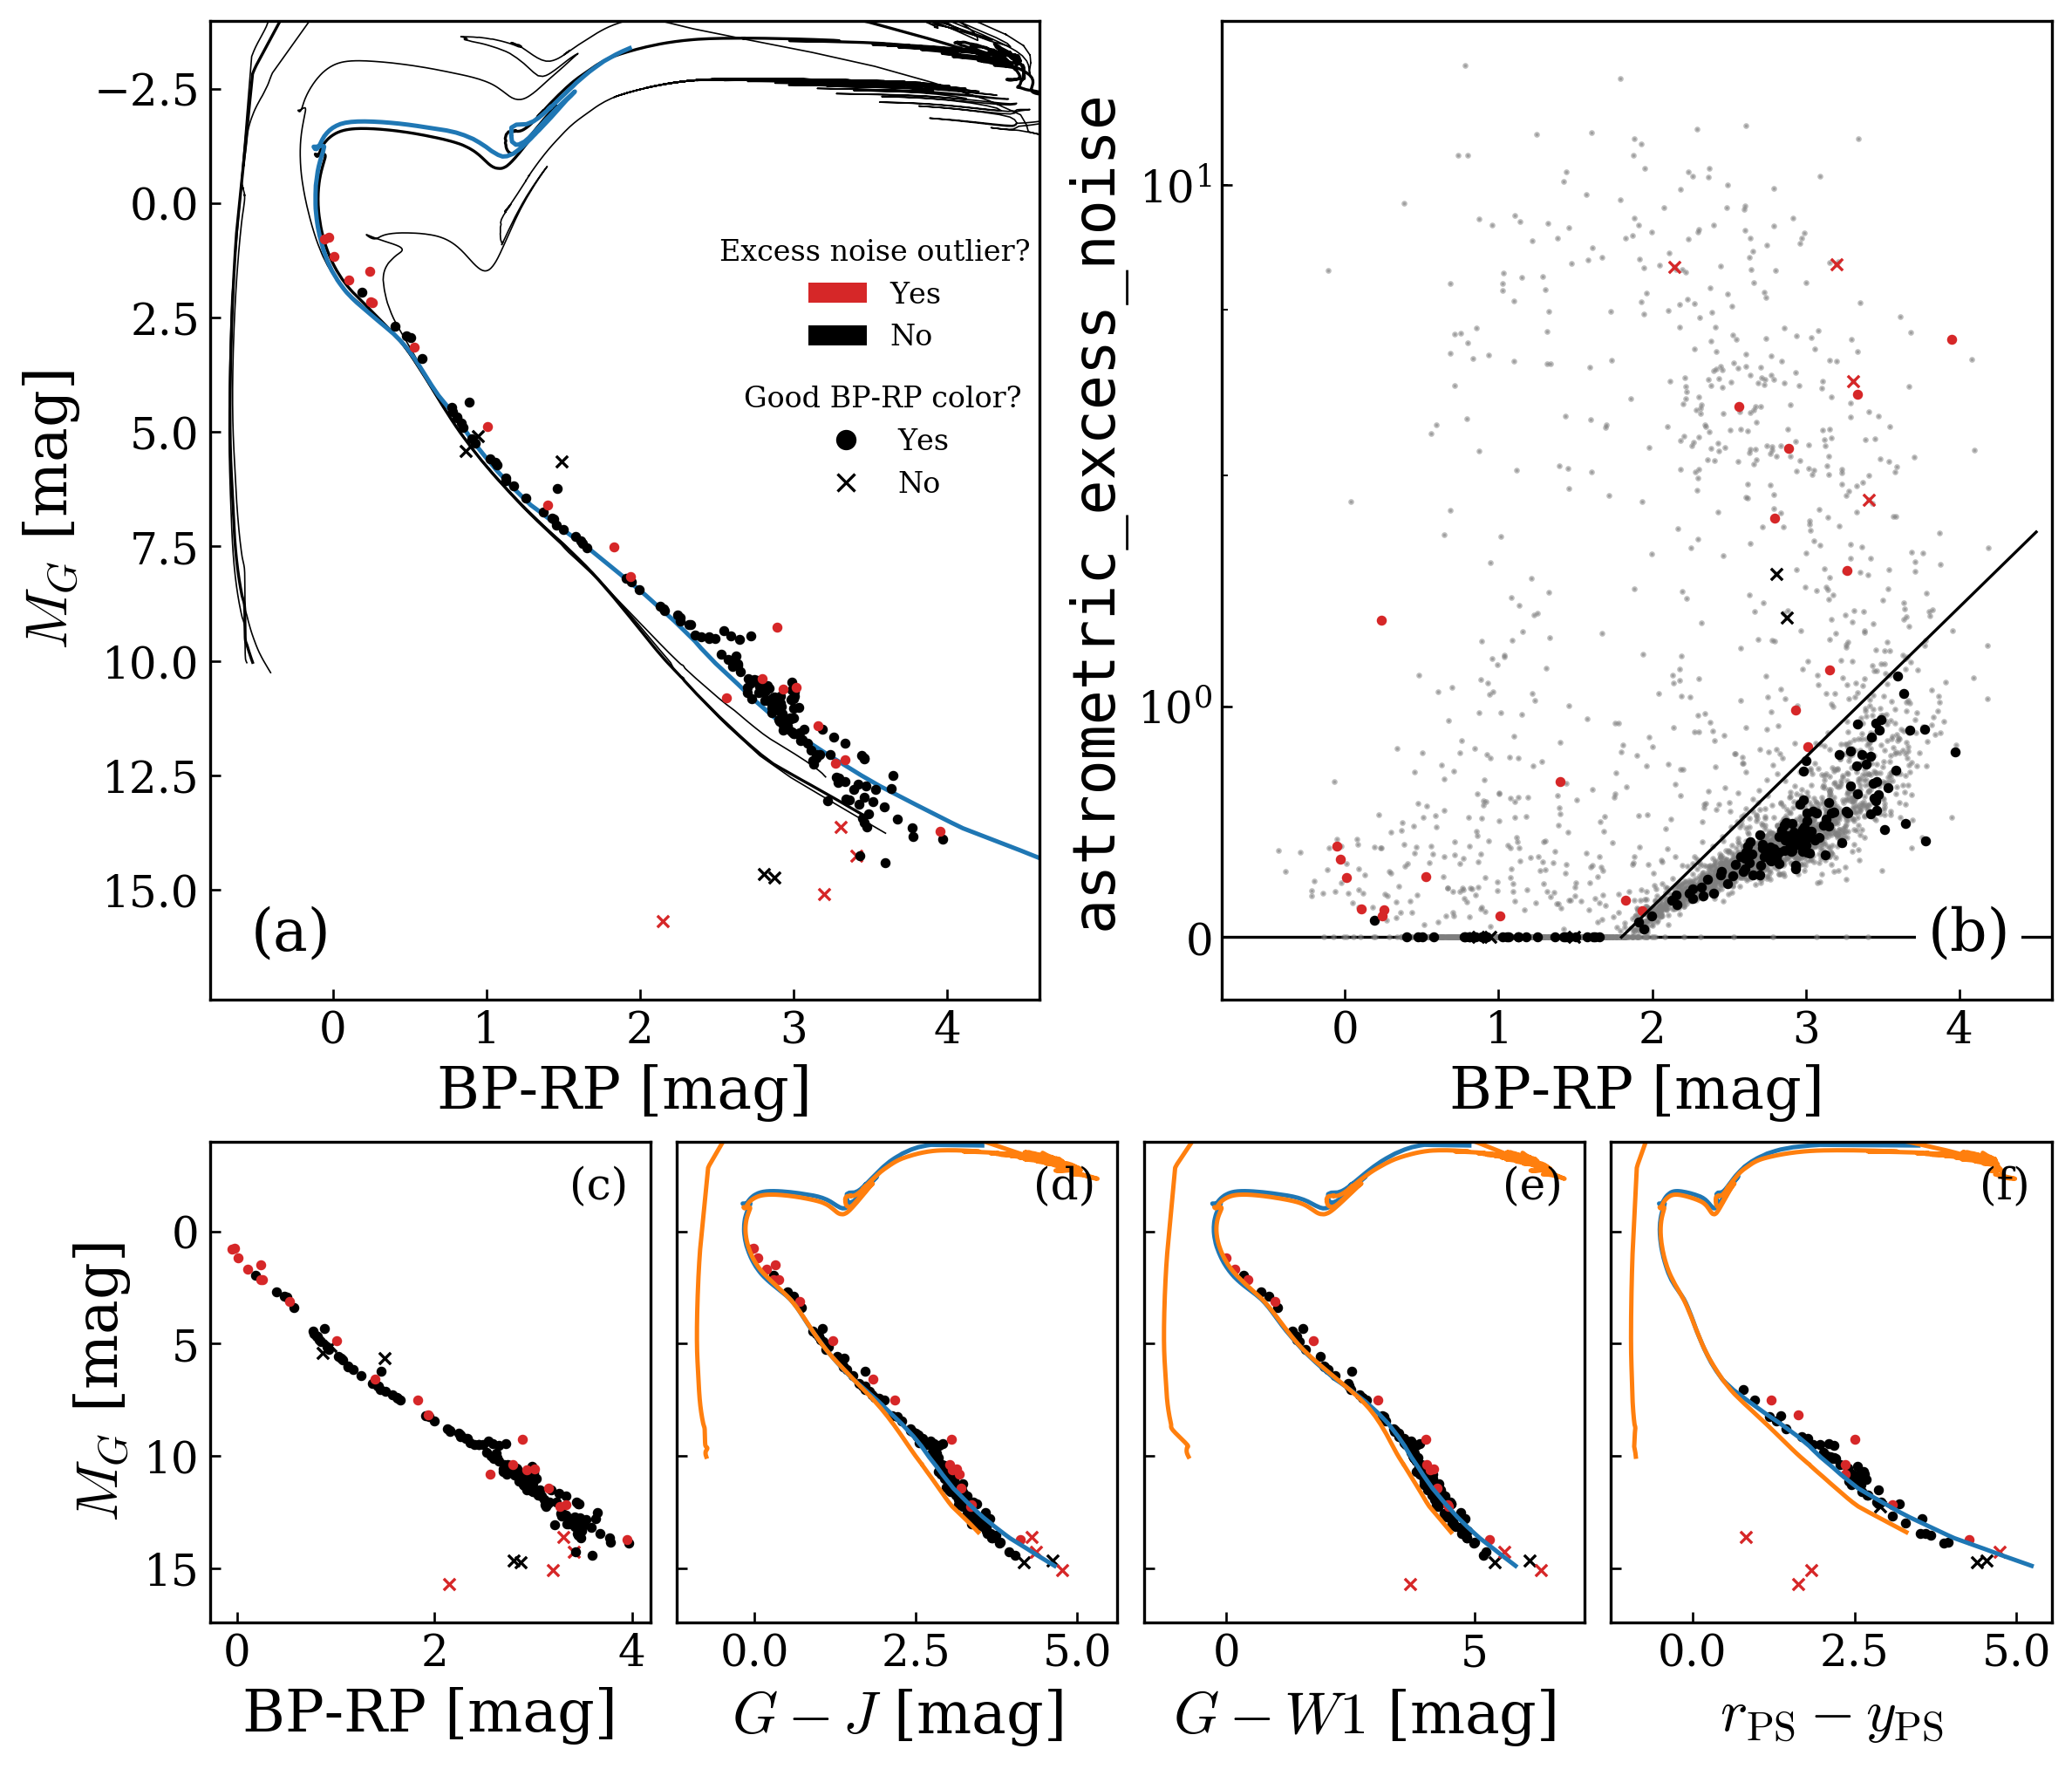

In [5]:
marker_by_phot = {True:None, False:'x'}
color_by_excess = {True:'tab:red', False:'k'}

fig, (ax,ax2) = plt.subplots(1, 2, figsize=(10,8.5), sharex=True)
fig.subplots_adjust(bottom=0.43, top=0.98, right=0.98, wspace=0.22, left=0.1)

for (phot,excess), grp in candi_phot.groupby(('good_phot','excess_excess')):
    s = 6 if marker_by_phot[phot] != 'x' else 16
    ax.scatter(grp.bp_rp, grp.phot_g_mean_mag+grp.distmod,
               c=color_by_excess[excess],
               marker=marker_by_phot[phot], s=s, lw=1)

isog.get_group(8.).plot('bp_rp', 'Gaia_G', ax=ax, c='k', lw=.5, ls='-', zorder=-5, label=None);
isog.get_group(8.4).plot('bp_rp', 'Gaia_G', ax=ax, c='k', lw=1, zorder=-5);
isog.get_group(9).plot('bp_rp', 'Gaia_G', ax=ax, c='k', lw=.5, ls='-', zorder=-5, label=None);
parsec_solar.groupby('log_age').get_group(8.4).iloc[:-10].plot('bp_rp', 'G', ax=ax, zorder=-5);

ax.set_ylim(17.4,-4)
ax.set_xlim(-0.8, 4.6)
ax.set_xlabel('BP-RP [mag]')
ax.set_ylabel('$M_G$ [mag]')
# ax.legend([allsources, candi_good_phot, candi_bad_phot],
#           ['Sources in queried region', 'Candidate member', 'Candidate member with bad photometry'])
ax.legend_.remove()
def add_legend(ax):
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_color = [Patch(facecolor='tab:red', label='Yes'),Patch(facecolor='k',label='No'), ]
    legend_marker = [Line2D([0],[0],marker='o', label='Yes', ls='None', c='k'),
                     Line2D([0],[0],marker='x', label='No', ls='None', c='k')]
    l1 = ax.legend(handles=legend_color, loc=(0.6,0.65), title='Excess noise outlier?',
                   frameon=False,fancybox=False)
    ax.legend(handles=legend_marker, loc=(0.63,0.5), title='Good BP-RP color?',
              frameon=False,fancybox=False)
    ax.add_artist(l1)
add_legend(ax)

g10_region.plot.scatter('bp_rp', 'astrometric_excess_noise', ax=ax2, c='tab:gray', alpha=.5, s=1)

for (phot,excess), grp in candi_phot.groupby(('good_phot','excess_excess')):
    s = 6 if marker_by_phot[phot] != 'x' else 16
    ax2.scatter(grp.bp_rp, grp.astrometric_excess_noise,
               c=color_by_excess[excess],
               marker=marker_by_phot[phot], s=s, lw=1)

x = np.linspace(1.8, 4.5)
y = (x-1.8)*0.65
plt.plot(x, y, 'k-', lw=1)

ax2.set_xlabel('BP-RP [mag]')
ax2.set_ylabel('astrometric_excess_noise', family='monospace')
ax2.axhline(0, c='k',lw=1,zorder=-5)
ax2.set_yscale('symlog')
ax2.set_yticks([0, 1, 2, 5, 10], ['0','1','2','5','10'])

from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 4,)
gs.update(left=0.1, right=0.98, top=0.35,bottom=0.08, wspace=0.06)
axcmd = [plt.subplot(x) for x in gs]

for (phot,excess), grp in candi_phot.groupby(('good_phot','excess_excess')):
#     axcmd[0].scatter(grp.bp_rp, grp.phot_g_mean_mag+grp.dm, s=2);
    s = 6 if marker_by_phot[phot] != 'x' else 16
    axcmd[0].scatter(
        grp.bp_rp, grp.phot_g_mean_mag+grp.distmod,
        c=color_by_excess[excess],
        marker=marker_by_phot[phot], s=s, lw=1)
    axcmd[1].scatter(
        grp.phot_g_mean_mag-grp.tmass_j, grp.phot_g_mean_mag+grp.distmod,
        c=color_by_excess[excess],
        marker=marker_by_phot[phot], s=s, lw=1)
    axcmd[2].scatter(
        grp.phot_g_mean_mag-grp.wise_w1, grp.phot_g_mean_mag+grp.distmod,
        c=color_by_excess[excess],
        marker=marker_by_phot[phot], s=s, lw=1)
    axcmd[3].scatter(
        grp.ps_r-grp.ps_y, grp.phot_g_mean_mag+grp.distmod,
        c=color_by_excess[excess],
        marker=marker_by_phot[phot], s=s, lw=1)
axcmd[0].set_xlabel('BP-RP [mag]')
axcmd[1].set_xlabel('$G-J$ [mag]')
axcmd[2].set_xlabel('$G-W1$ [mag]')
axcmd[3].set_xlabel('$r_\mathrm{PS}-y_\mathrm{PS}$')
for a in axcmd[1:]: a.tick_params(labelleft='off')
for a in axcmd: a.set_ylim(ax.get_ylim())
axcmd[0].set_ylabel('$M_G$ [mag]')

tmp = parsec_solar.groupby('log_age').get_group(8.4)
axcmd[1].plot(tmp.G-tmp.J, tmp.G,);
axcmd[2].plot(tmp.G-tmp.W1, tmp.G,);
axcmd[3].plot(tmp.rP1-tmp.yP1, tmp.G,);

tmp = isog.get_group(8.4)
axcmd[1].plot(tmp.Gaia_G-tmp['2MASS_J'], tmp.Gaia_G,);
axcmd[2].plot(tmp.Gaia_G-tmp['WISE_W1'], tmp.Gaia_G,);
axcmd[3].plot(tmp.PS_r-tmp.PS_y, tmp.Gaia_G,);

# label subplots
ax.text(0.05,0.05, '(a)', transform=ax.transAxes, size=20)
ax2.text(0.95,0.05, '(b)', transform=ax2.transAxes, size=20, ha='right',
         bbox=dict(facecolor='w', edgecolor='None'))
for a, label in zip(axcmd, 'cdef'):
    a.text(0.95,0.95, '('+label+')', transform=a.transAxes, size=15, ha='right', va='top')

# fig.savefig('../paper/figures/bp_rp_G.pdf')

## Interactive cmd

In [123]:
# iso = hiso.query('''
# select *, Gaia_BP-Gaia_RP as bp_rp from mist where feh in (0.25, 0, -0.25)
# ''')
# iso.log_age = np.round(iso.log_age, 2)
# isog = iso.groupby(('FeH', 'log_age'))

# import ipywidgets as widgets
# from ipywidgets import interactive

# plt.figure(2, figsize=(4,4))
# def f(log_age):
#     for c,feh in zip(['b','k','r'],[-0.25, 0, 0.25]):
#         tmp = isog.get_group((feh,log_age))
#         plt.plot(tmp['2MASS_J']-tmp['2MASS_Ks'], tmp['2MASS_J'], c=c, lw=1);
#     plt.ylim(15,-5)
#     plt.xlim(-.5, 2)
#     plt.scatter(candi_phot.tmass_j-candi_phot.tmass_ks,candi_phot.tmass_j+candi_phot.dm,s=2)
#     plt.show()


# interactive_plot = interactive(f, log_age=widgets.FloatSlider(min=7, max=9, step=0.05))
# output = interactive_plot.children[-1]
# output.layout.height = '550px'
# interactive_plot


# plt.scatter(candi_phot.tmass_j-candi_phot.tmass_h,candi_phot.tmass_j+candi_phot.dm,s=2)
# plt.gca().invert_yaxis()
# plt.plot(tmp['2MASS_J']-tmp['2MASS_H'], tmp['2MASS_J'], c='k');

# Total mass estimate

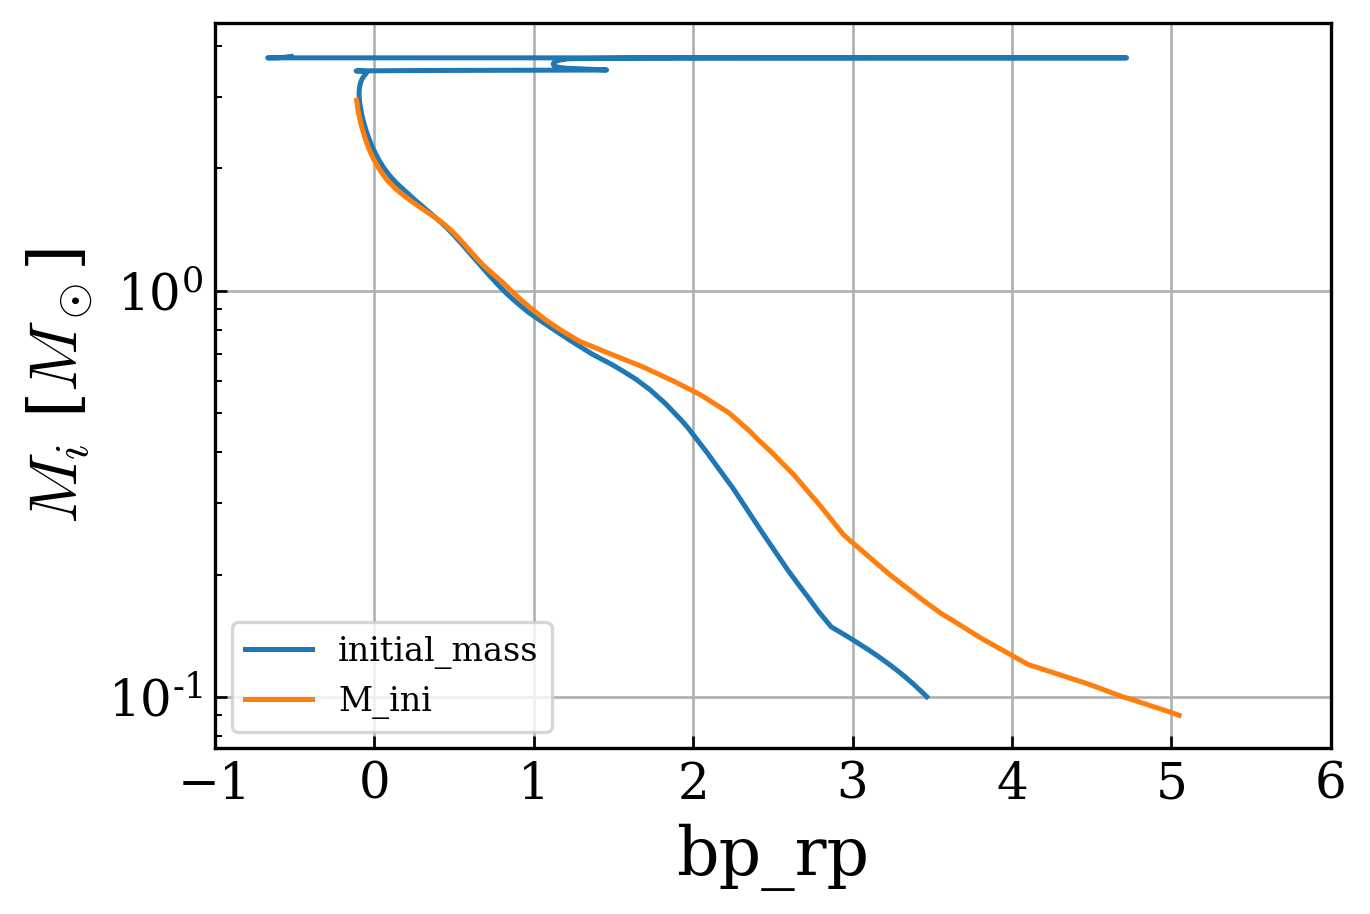

In [6]:
isog.get_group(8.4).plot('bp_rp', 'initial_mass', ax=plt.gca())
parsec_solar.groupby('log_age').get_group(8.4)\
    .query('bp_rp>-.5 and M_ini<3')\
    .plot('bp_rp', 'M_ini', ax=plt.gca())
plt.xlim(-1,6)
plt.yscale('log')
plt.grid()
plt.ylabel('$M_i$ [$M_\odot$]');

In [7]:
from scipy import interpolate
iso = parsec_solar.groupby('log_age').get_group(8.4)\
    .query('bp_rp>-.5 and M_ini<3')
bprp_to_mass = interpolate.interp1d(iso.G_BP-iso.G_RP, iso.M_ini)

In [8]:
print('bp_rp = 0, 3 ->',list(map(bprp_to_mass, [0,3])))

bp_rp = 0, 3 -> [array(2.09333324), array(0.24041812)]


In [9]:
print('number of stars in bp_rp (0, 3) =', len(candi_phot.query('bp_rp>0 & bp_rp<3 & good_phot==True')))

number of stars in bp_rp (0, 3) = 124


In [10]:
mass_bprp03 = np.sum(list(map(bprp_to_mass, candi_phot.query('bp_rp>0 & bp_rp<3 & good_phot==True').bp_rp.values)))
print('total mass in bp_rp (0, 3) = {:.2f} solar masses'.format(mass_bprp03))

total mass in bp_rp (0, 3) = 69.46 solar masses


In [11]:
totmass = mass_bprp03*2.4
print('total mass assuming Kroupa IMF = {:.2f} solar masses'.format(totmass))

total mass assuming Kroupa IMF = 166.71 solar masses


# Other age estimates

## Age estimates from David & Hillenbrand 2015

In [7]:
print('check there is no missing HIP ID in DH2015')
assert dht5.HIP.isnull().sum() == 0

check there is no missing HIP ID in DH2015


In [8]:
candi_with_age = candi.reset_index().merge(g10_region_tycho2, how='left', on='designation')\
    .merge(dht5, how='left', left_on='hip', right_on='HIP').set_index('index')\
    .dropna(subset=['HIP'])
candi_with_age.filter(regex='Age')

,Ageavg,Agemed,Agemod,Age68lo,Age68up,Age68t,Age95lo,Age95up,Age95t,Age2D
index,,,,,,,,,,
1775,1673.0,1793.0,1804.0,1403.0,2415.0,68.0,649.0,4097.0,95.0,377.0
2459,134.0,159.0,241.0,88.0,404.0,68.0,22.0,487.0,95.0,151.0
2480,108.0,134.0,202.0,87.0,265.0,68.0,21.0,290.0,95.0,207.0
2562,118.0,142.0,214.0,84.0,325.0,68.0,21.0,376.0,95.0,202.0
2639,110.0,137.0,202.0,80.0,310.0,68.0,19.0,345.0,95.0,201.0


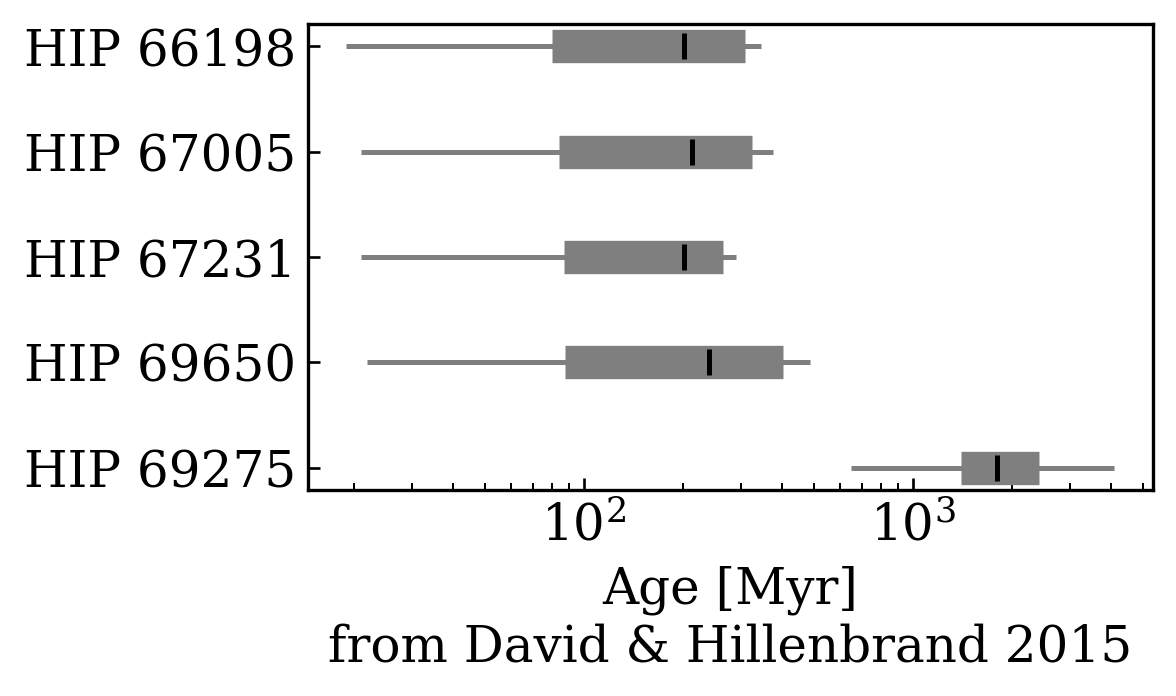

In [12]:
plt.figure(figsize=(5,3))
dfplot = candi_with_age.reset_index(drop=True).copy()

xerr68 = [dfplot.Agemod-dfplot.Age68lo, dfplot.Age68up-dfplot.Agemod]
xerr95 = [dfplot.Agemod-dfplot.Age95lo, dfplot.Age95up-dfplot.Agemod]

plt.scatter(dfplot.Agemod, dfplot.index, marker='|', c='k', zorder=6, lw=1.5, s=64)
# plt.scatter(dfplot.Ageavg, dfplot.index, marker='v', c='k', zorder=6, lw=1.5,)
plt.errorbar(dfplot.Agemod, dfplot.index, xerr=xerr68, ls='None', lw=10, c='tab:gray', zorder=5)
plt.errorbar(dfplot.Agemod, dfplot.index, xerr=xerr95, ls='None', c='tab:gray')
plt.xscale('log')
plt.yticks(dfplot.index, ['HIP {:.0f}'.format(x) for x in dfplot.HIP]);
plt.xlabel('Age [Myr]\nfrom David & Hillenbrand 2015', size=15);
plt.tight_layout()
plt.savefig('../paper/figures/age_DavidHillenbrand2015.pdf')

In [18]:
candi_with_age.sort_values('bp_rp').filter(regex='excess|bp_rp|HIP')

,astrometric_excess_noise,astrometric_excess_noise_sig,phot_bp_rp_excess_factor,bp_rp,HIP
index,,,,,
2480,0.395659,76.226288,1.128073,-0.051988,67231.0
2639,0.339379,53.874596,1.144437,-0.028392,66198.0
2562,0.257980,32.674475,1.142844,0.010413,67005.0
2459,0.121633,6.917588,1.139776,0.107178,69650.0
1775,0.261362,22.763946,1.169307,0.528795,69275.0


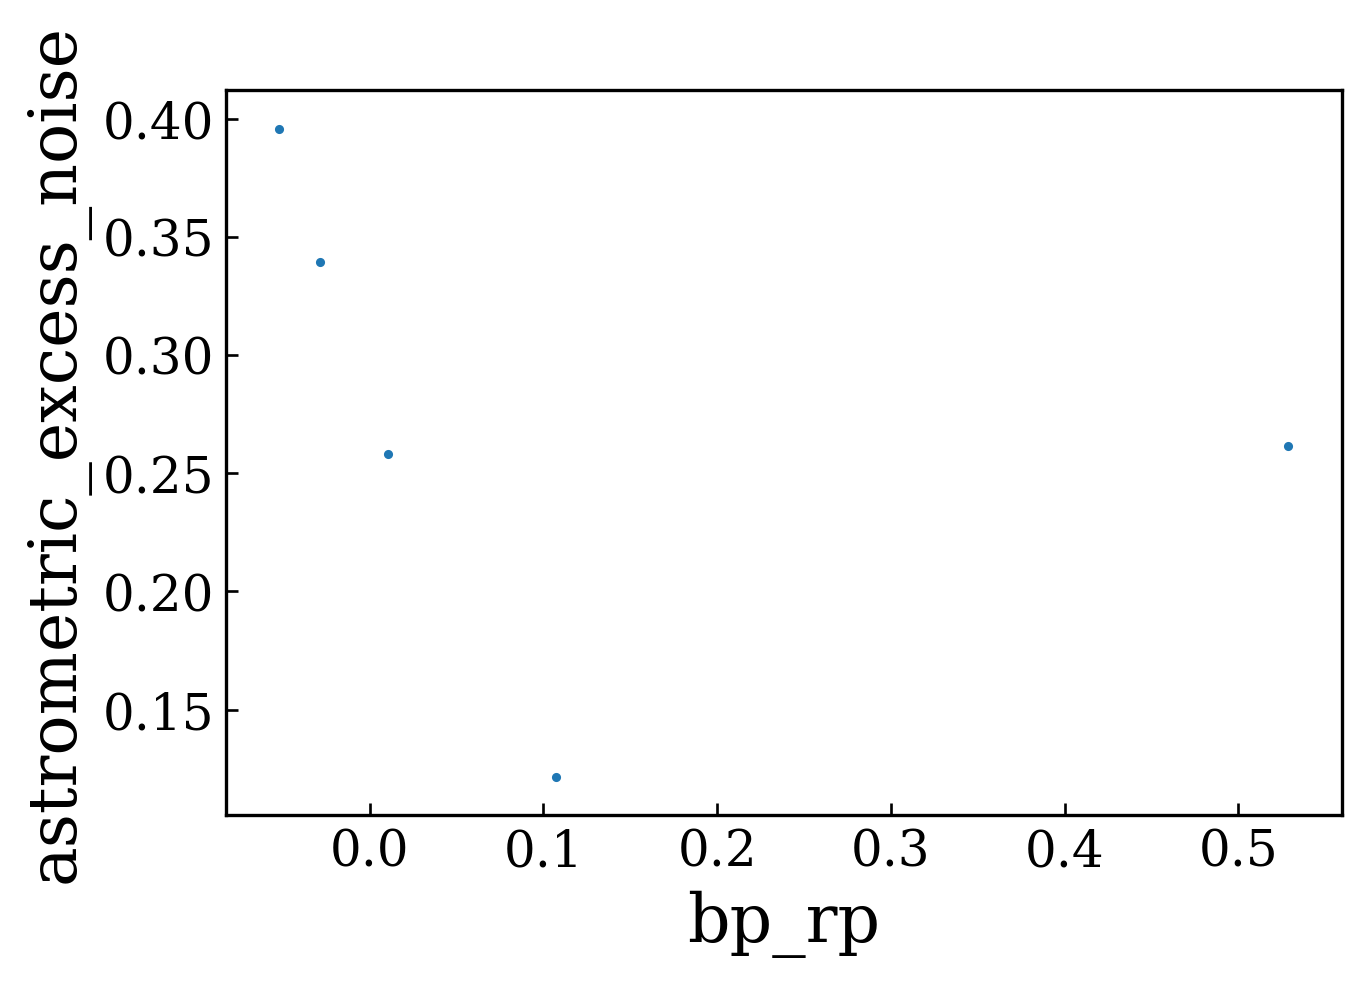

In [15]:
candi_with_age.plot.scatter('bp_rp', 'astrometric_excess_noise',s=3)

## Bochanski ages

In [13]:
b18 = Table.read('../data/bochanski2018_table1.txt', format='ascii.cds').to_pandas()

print(len(b18), b18.columns)
# match using dr1 source id
g_b18 = g[['row_id','name','source_id','hip','tycho2_id']]\
    .merge(g_dr2, left_on='source_id', right_on='dr1_source_id', how='left')\
    .merge(b18, left_on='dr1_source_id', right_on='TGAS', how='left')

9754 Index(['TGAS', 'RAdeg', 'DEdeg', 'Mass', 'E_Mass', 'e_Mass', 'Radius',
       'E_Radius', 'e_Radius', '[Fe/H]', 'E_[Fe/H]', 'e_[Fe/H]', 'LogAge',
       'E_LogAge', 'e_Age', 'Dist', 'E_Dist', 'e_Dist', 'Av', 'E_Av', 'e_Av'],
      dtype='object')


<Container object of 3 artists>

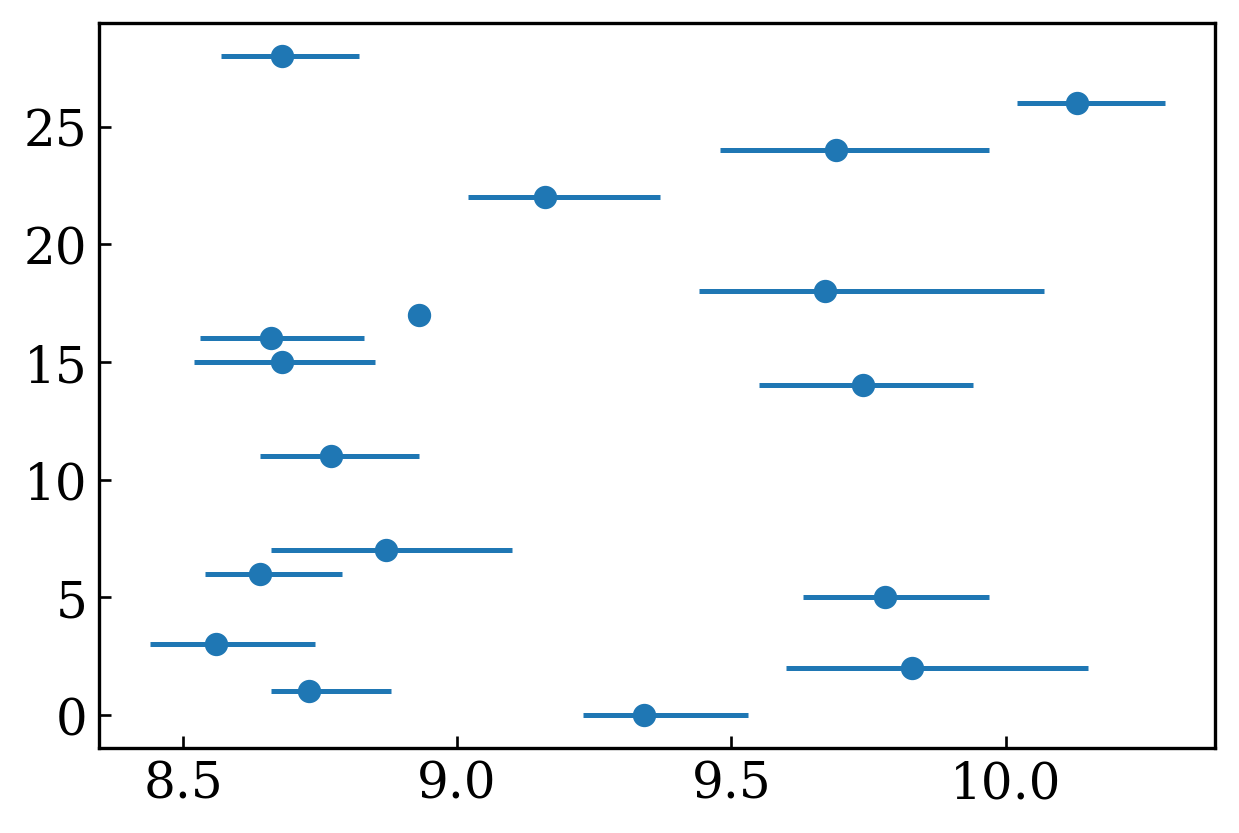

In [14]:
plt.errorbar(g_b18['LogAge'], np.arange(len(g_b18)), xerr=[g_b18['e_Age'], g_b18['E_LogAge']], fmt='o')

<Container object of 3 artists>

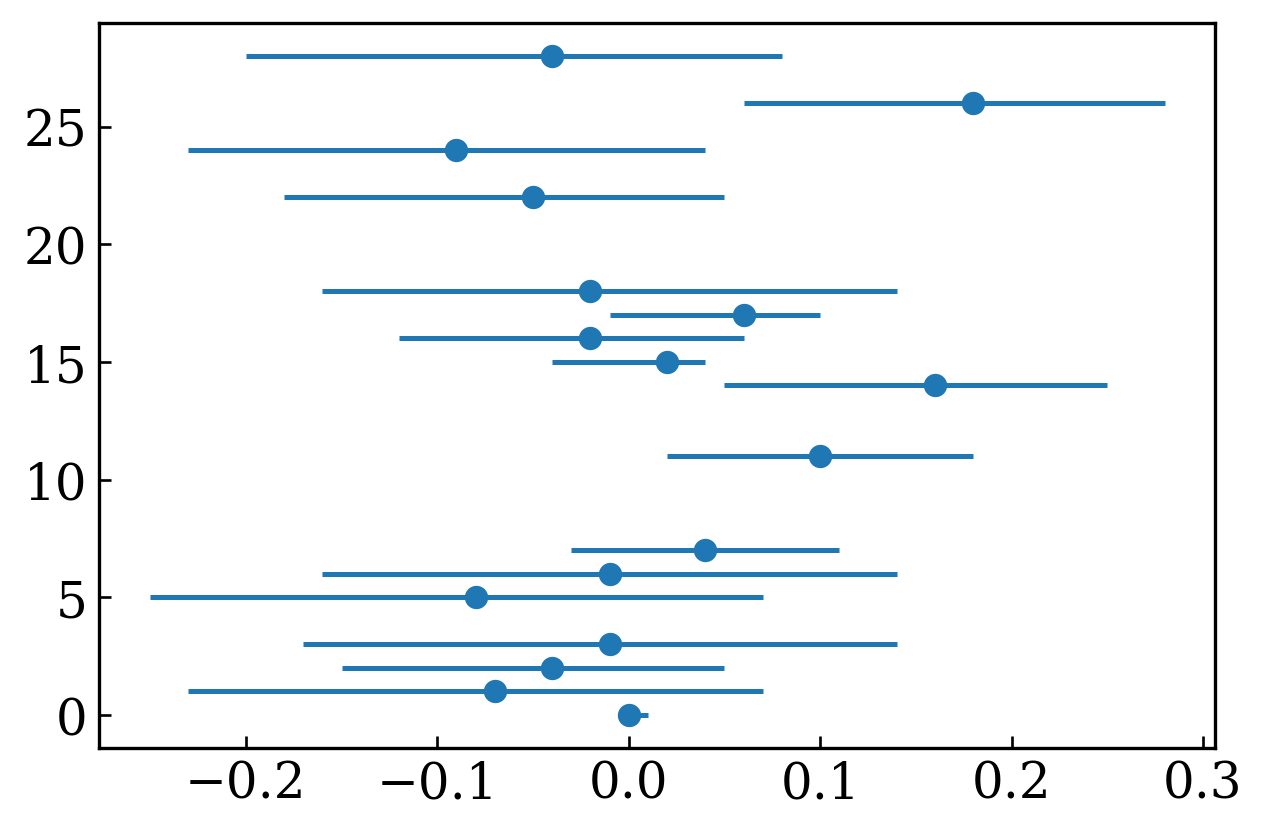

In [15]:
plt.errorbar(g_b18['[Fe/H]'], np.arange(len(g_b18)), xerr=[g_b18['e_[Fe/H]'], g_b18['E_[Fe/H]']], fmt='o')

# X-ray crossmatch

In [180]:
candicoords = coords.SkyCoord(candi.ra.values*u.deg, candi.dec.values*u.deg)
idx, angsep, _ = candicoords.match_to_catalog_sky(RXS.coords_2rxs)

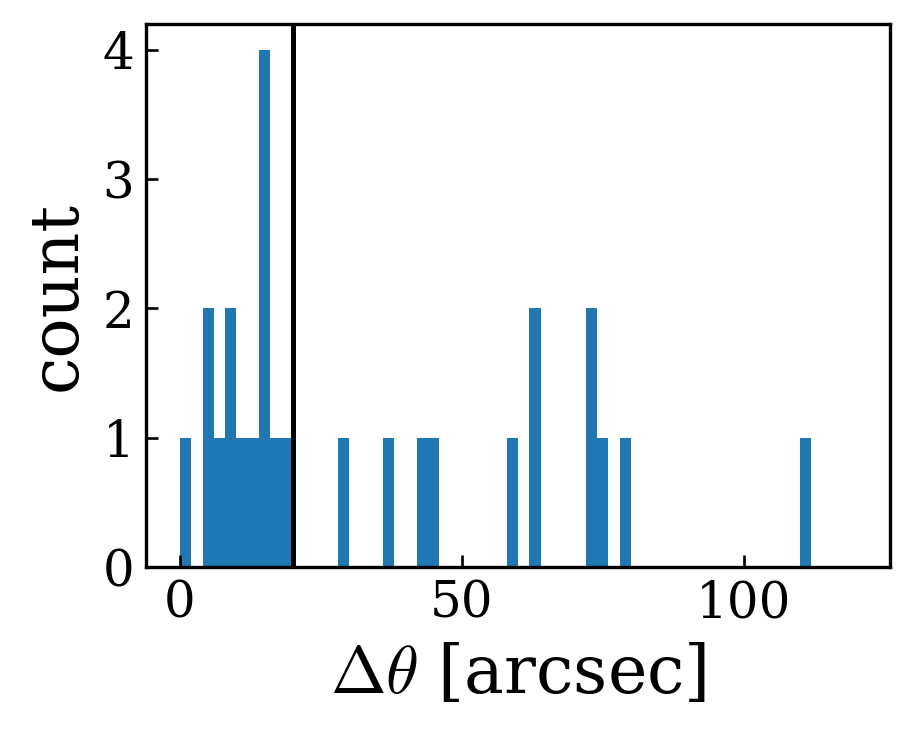

In [181]:
plt.figure(figsize=(4,3))
plt.hist(angsep.to(u.arcsec), np.linspace(0,120,61));
plt.xlabel(r'$\Delta \theta$ [arcsec]')
plt.ylabel('count');
plt.axvline(20, c='k');

In [182]:
match = angsep < 20*u.arcsec
print('number of sources with X-ray source matched within 20 arcsec = {:d}'.format(match.sum()))

number of sources with X-ray source matched within 20 arcsec = 14


In [183]:
candi_phot_xray = pd.DataFrame(index=candi_phot.index)
candi_phot_xray = candi_phot_xray.assign(is_xray_source=match)
candi_phot_xray.loc[match, 'idx_2rxs'] = idx[match]
candi_phot_xray.loc[match, 'angsep_2rxs_arcsec'] = angsep.to(u.arcsec)[match]

for name in ['CTS', 'CERR', 'RATE', 'ERATE']:
    candi_phot_xray.loc[match, name] = RXS.t_2rxs[name].data[candi_phot_xray.idx_2rxs.values[match].astype(int)]

# using FLUX_p
# LX = (RXS.t_2rxs['FLUX_p'][idx[match]].data*u.erg/u.s/u.cm**2
#       * (4*np.pi *(1000./candi.parallax.values[match]*u.pc)**2))\
#     .to(u.erg/u.s)
# using count rate and conversion factor
LX = (RXS.t_2rxs['RATE'][matchtable.idx_2rxs.values].data* 1.08E-11*u.erg/u.s/u.cm**2
      * (4*np.pi *(1000./candi.iloc[matchtable.idx_candi.values].parallax.values*u.pc)**2)).to(u.erg/u.s)
LX_err = (RXS.t_2rxs['ERATE'][matchtable.idx_2rxs.values].data* 1.08E-11*u.erg/u.s/u.cm**2
      * (4*np.pi *(1000./candi.iloc[matchtable.idx_candi.values].parallax.values*u.pc)**2)).to(u.erg/u.s)
candi_phot_xray.loc[match, 'LX'] = LX.value
candi_phot_xray.loc[match, 'LX_err'] = LX_err.value

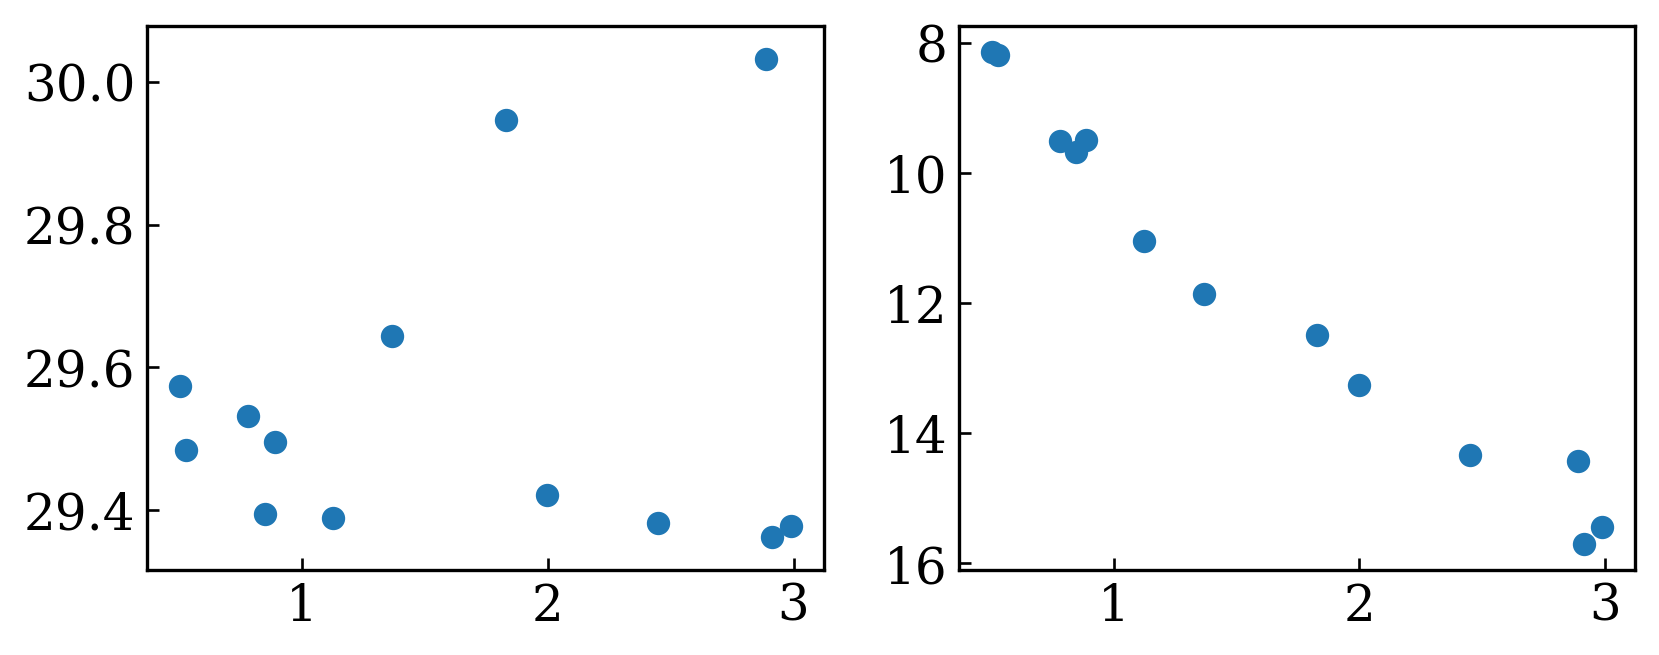

In [184]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].scatter(candi_phot.bp_rp, np.log10(candi_phot_xray.LX))
ax[1].scatter(candi_phot.loc[candi_phot_xray.is_xray_source,'bp_rp'],
              candi_phot.loc[candi_phot_xray.is_xray_source, 'phot_g_mean_mag'])
plt.gca().invert_yaxis()

# GALEX crossmatch

In [12]:
from astroquery.mast import Catalogs
from tqdm import tqdm

In [48]:
tables = {}
for row in tqdm(candi[['ra','dec']].itertuples(), total=len(candi)):
    obj = '{:.5f} {:.5f}'.format(row.ra, row.dec)
    t = Catalogs.query_object(obj, catalog='Galex', radius=2*u.arcsec)
    if len(t)>0:
        tables[row.Index]=t

100%|██████████| 194/194 [02:10<00:00,  1.48it/s]


In [49]:
len(tables.keys())

62

In [250]:
for k, t in tables.items():
    t['candi_index'] = [k]*len(t)
dfs = list(map(table_to_pandas, tables.values()))

In [251]:
galexmatch = pd.concat(dfs, axis=0)

galexmatch = galexmatch.reset_index(drop=True)

In [252]:
print('number of candidate members with GALEX within 2 arcsec = {:d}'.format(
    galexmatch.candi_index.unique().size))

number of candidate members with GALEX within 2 arcsec = 62


In [253]:
print('number of candidate members with multiple matches within 2 arcsec = {:d}'.format(
    (galexmatch.candi_index.value_counts()>1).sum()))

number of candidate members with multiple matches within 2 arcsec = 18


In [254]:
# select smalles nuv_magerr for duplicates
galexmatch_dedup = galexmatch.sort_values('nuv_magerr').drop_duplicates('candi_index')

In [281]:
# trick to make row-by-row match to candi_phot
candi_phot_galex = galexmatch_dedup.merge(
    candi_phot[['designation']].reset_index(), left_on='candi_index', right_on='index', how='right')\
    .set_index('index').sort_index()

In [106]:
mistiso = hiso.query("select log_age, initial_mass, eep, Gaia_g, gaia_bp, gaia_rp, galex_nuv from mist where feh=0")\
    .groupby('log_age').get_group(8.4)
parseciso = parsec_solar.groupby('log_age').get_group(8.4)

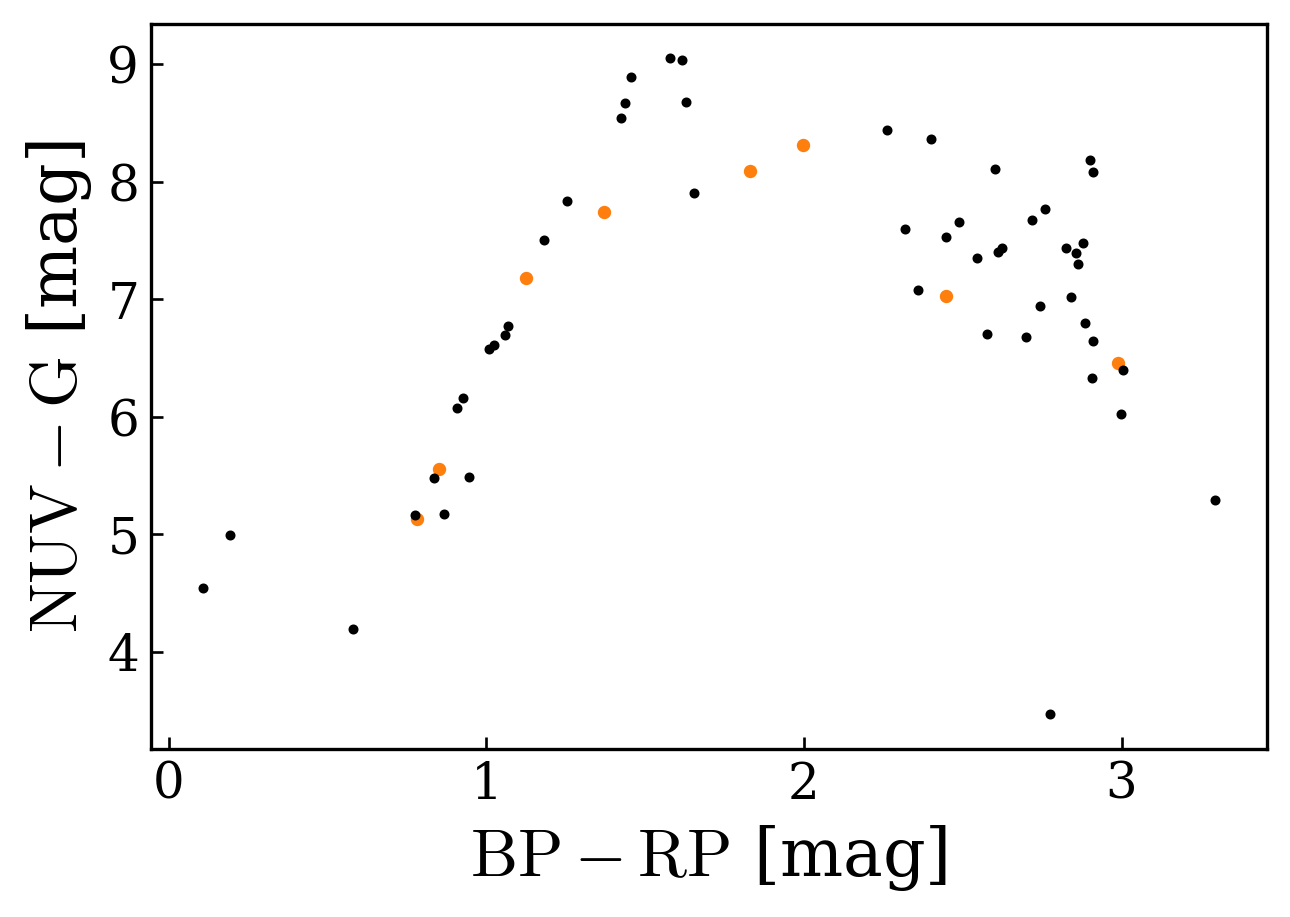

In [288]:
is_xraysrc = candi_phot_xray.idx_2rxs.notnull()
plt.scatter(candi_phot.bp_rp[is_xraysrc], candi_phot_galex.nuv_mag[is_xraysrc]-candi_phot.phot_g_mean_mag[is_xraysrc], c='tab:orange', s=9)
plt.scatter(candi_phot.bp_rp[~is_xraysrc], candi_phot_galex.nuv_mag[~is_xraysrc]-candi_phot.phot_g_mean_mag[~is_xraysrc], c='k', s=4)
# plt.axis([0.4, 1.7,3.5,12])

plt.xlabel(r'$\mathrm{BP}-\mathrm{RP}$ [mag]')
plt.ylabel(r'$\mathrm{NUV} - \mathrm{G}$ [mag]')

# Dust maps

In [41]:
from dustmaps.sfd import SFDQuery
from dustmaps.lenz2017 import Lenz2017Query

In [60]:
c = make_icrs(candi)
sfd = SFDQuery()
ebv = sfd(c)

print('median E(B-V) = {:.3f} mag'.format(np.median(ebv)))

median E(B-V) = 0.013 mag


In [64]:
ebv_lenz17 = Lenz2017Query()(c)
print('median E(B-V) = {:.3f} mag'.format(np.median(ebv_lenz17)))

Filename: /Users/semyeong/data/dustmaps/lenz2017/ebv_lhd.hpx.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     30   12582912R x 1C   [E]   
None
median E(B-V) = 0.012 mag


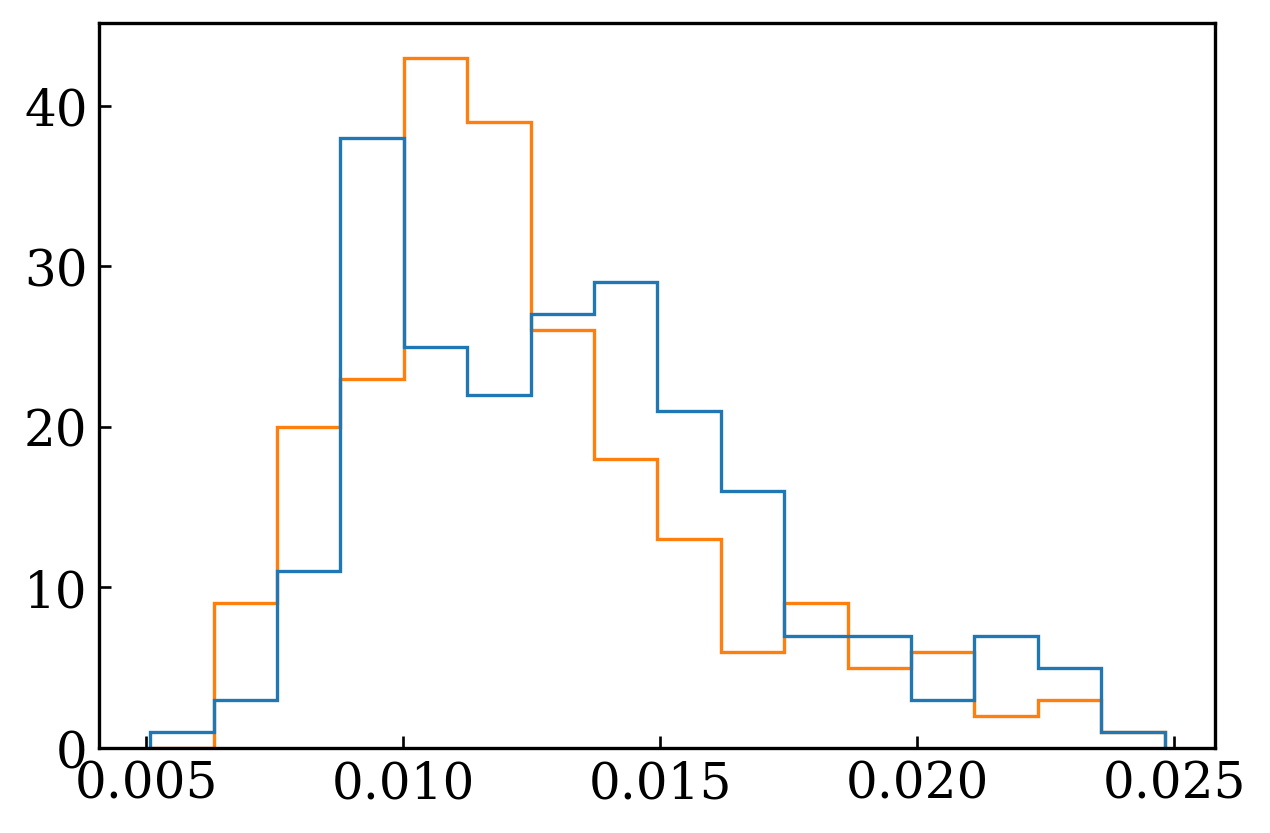

In [67]:
plt.hist([ebv, ebv_lenz17], histtype='step', bins=16);

In [69]:
stats.describe(ebv_lenz17)

DescribeResult(nobs=223, minmax=(0.0066754999570548534, 0.024575959891080856), mean=0.012494785015809563, variance=1.2946573674335649e-05, skewness=0.9736265886736992, kurtosis=0.7226155223318234)